In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import optuna
import wandb
import gc

import os
import sqlite3

gpus = tf.config.list_physical_devices('GPU')
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gc.collect()
tf.keras.backend.clear_session()

# Carga de los datos 

df = pd.read_csv("/Plant-Pathology-Classificator/plant-pathology-2020-/train.csv")

df["label"] = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)

df["filepath"] = df['image_id'].apply(lambda x: os.path.join("/Plant-Pathology-Classificator/plant-pathology-2020-/images", f'{x}.jpg'))


from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(df, test_size = 0.5, stratify = df["label"], random_state = 4)

X_test, X_val = train_test_split(X_temp, test_size = 0.4, stratify = X_temp["label"], random_state = 4)

mini_train, _ = train_test_split(X_train, test_size = 0.6, stratify = X_train["label"], random_state = 4)

mini_val, _ = train_test_split(X_val, test_size = 0.2, stratify = X_val["label"], random_state = 4)

In [2]:
def random_contrast(img):
    # Aumentar contraste
    factor = 1.7
    mean = np.mean(img, axis = (0,1), keepdims = True)
    img = (img - mean) * factor + mean
    img = np.clip(img, 0, 255)
    
#     # Aumentar tonos cálidos
#     warm_factor = np.random.uniform(1.0, 1.3)
#     img = img.astype(np.float32)
#     img[..., 0] *= 1.0           
#     img[..., 1] *= warm_factor   
#     img[..., 2] *= warm_factor
    
    return img.astype(np.float32)

import numpy as np

def tone_filter_green_blue(img):
    """Reduce green in low lights, boost blue in low-mid lights"""
    img = img.astype(np.float32)

    r = img[..., 0]
    g = img[..., 1]
    b = img[..., 2]

    g = g - 0.4 * (255 - g)**2 * (g < 128) # Reducción tonos oscuros, canal verde

    mask = (b < 128)
    b = np.where(mask, b + 0.5 * (128 - b), b)  # Aumento tonos oscuros, canal azul

    img = np.stack([r, np.clip(g, 0, 255), np.clip(b, 0, 255)], axis=-1)

    return img.astype(np.float32)

import numpy as np

def lift_dark_greens(img):
    """Brighten dark green tones, shifting them slightly toward mid-tones."""
    img = img.astype(np.float32) / 255.0

    # Compute luminance
    lum = 0.299 * img[..., 0] + 0.587 * img[..., 1] + 0.114 * img[..., 2]

    # Identify green-dominant pixels
    green_mask = (img[..., 1] > img[..., 0]) & (img[..., 1] > img[..., 2])

    # Focus on dark areas (shadows)
    dark_mask = lum < 0.4

    # Combine masks
    target_mask = green_mask & dark_mask

    # Create a brightness lift factor
    factor = np.ones_like(lum)
    factor[target_mask] *= 1.25   

    # Optional: smooth transitions around mask edges
    # (avoids sharp tonal jumps)
    factor = np.clip(factor, 1.0, 1.3)

    # Apply proportional scaling to all channels
    img = img * factor[..., np.newaxis]
    img = np.clip(img, 0, 1)

    return (img * 255).astype(np.float32)

def boost_orange(img):
    
    img = img.astype(np.float32) / 255.0
    
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    
    # Hue range for orange (in [0, 1] scale)
    orange_mask = ((h > 0.05) & (h < 0.12)) 
    
    # Boost saturation and luminance/value for orange pixels
    s[orange_mask] = np.clip(s[orange_mask] * 1.8, 0, 1) 
    v[orange_mask] = np.clip(v[orange_mask] * 1.8, 0, 1)  
    
    # Merge and convert back to RGB
    hsv_mod = cv2.merge([h, s, v])
    rgb = cv2.cvtColor(hsv_mod, cv2.COLOR_HSV2RGB)
    
    return (rgb * 255).astype(np.float32)

In [3]:
def custom_preprocessing(img):
    
    img = random_contrast(img)
    img = tone_filter_green_blue(img)
    #img = tone_curve_filter(img)
    img = lift_dark_greens(img)
    boost_orange(img)
    
    return img

In [4]:
datagen_train = ImageDataGenerator(
    preprocessing_function = custom_preprocessing,
    rescale = 1./255,
    rotation_range = 30 ,          
    width_shift_range = 0.2,      
    height_shift_range = 0.2,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (0.9, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "reflect")

datagen_test_and_val = ImageDataGenerator(rescale = 1./255,
                                          preprocessing_function = custom_preprocessing,
                                          dtype = "float32")

In [5]:
mini_train_filter = datagen_train.flow_from_dataframe(
    dataframe = mini_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 32,
    shuffle = True,
    seed = 4
)

mini_val_filter = datagen_test_and_val.flow_from_dataframe(
    dataframe = mini_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = False,
    seed = 4,
)

Found 364 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.


In [6]:
datagen_train2 = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30 ,          
    width_shift_range = 0.2,      
    height_shift_range = 0.2,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (0.9, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "reflect")

datagen_test_and_val2 = ImageDataGenerator(rescale = 1./255,
                                          dtype = "float32")

In [7]:
mini_train = datagen_train2.flow_from_dataframe(
    dataframe = mini_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 32,
    shuffle = True,
    seed = 4
)

mini_val = datagen_test_and_val2.flow_from_dataframe(
    dataframe = mini_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = False,
    seed = 4,
)

Found 364 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.


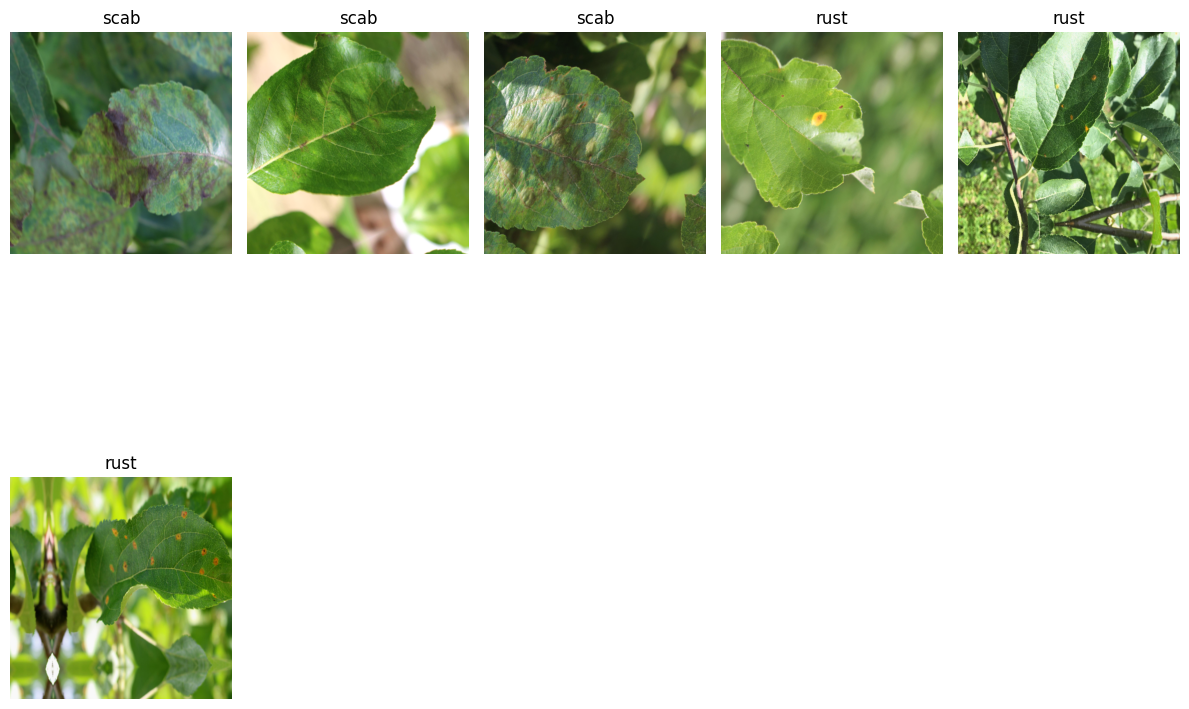

In [8]:
# Get one batch
img, labels = next(mini_train)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 10))
for i in range(6):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

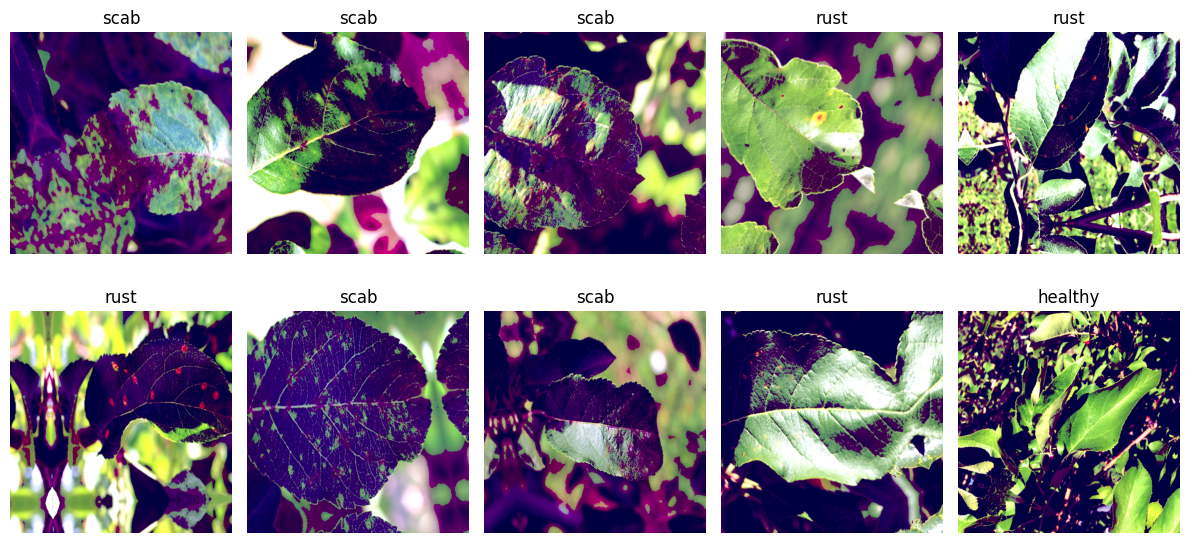

In [9]:
# Get one batch
img, labels = next(mini_train_filter)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train_filter.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 6))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

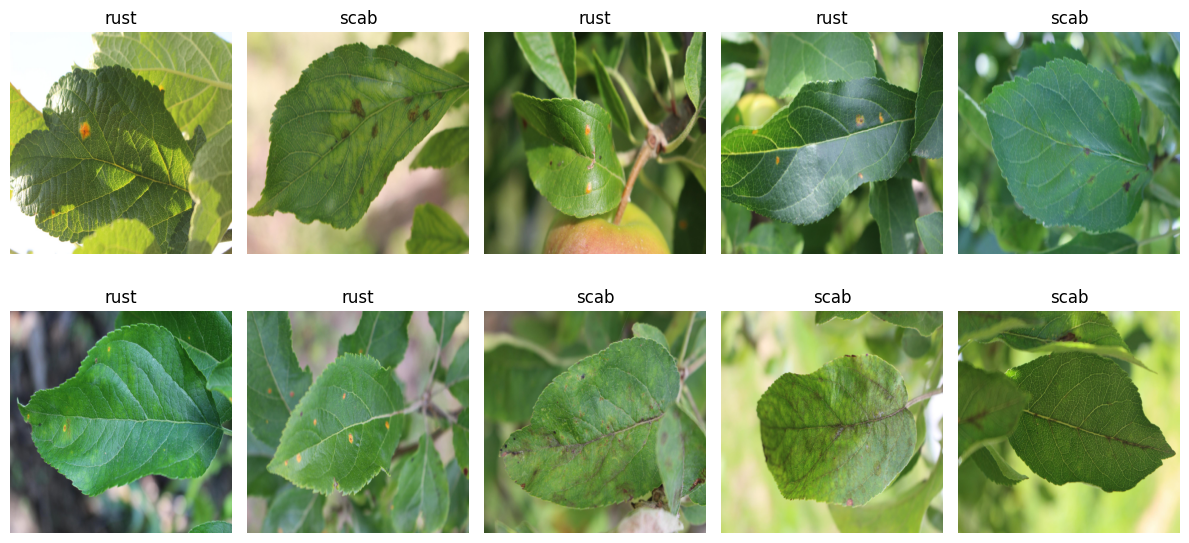

In [10]:
# Get one batch
img, labels = next(mini_val)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 6))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

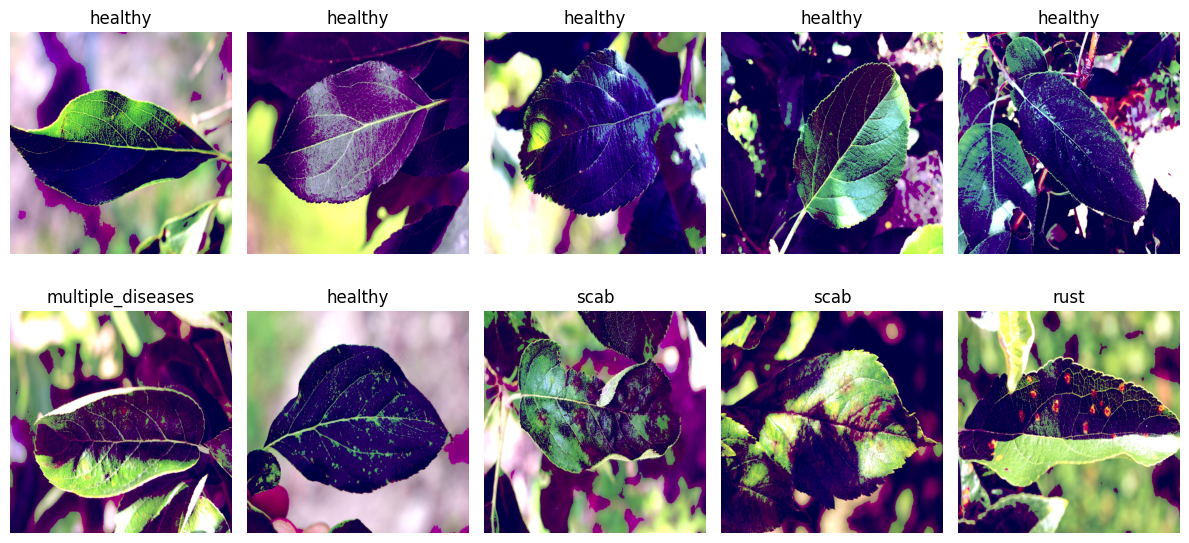

In [13]:
# Get one batch
img, labels = next(mini_val_filter)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 6))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()